# Homework 4 Q1

In [115]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.compose import make_column_transformer
from matplotlib import pyplot as plt
import seaborn as sns
import time

# Task 1: Normalize Features
- HotOneEncode Categorical Columns
- Convert age to numerical value  below21 converts to 16 and 50plus to 55
    - Or convert age to ordinal encoding
- Convert eduction to ordinal encoding 
- Convert income to ordinal encoding
Key Decision: Converting categorical columns with only two outputs to 0 and 1 instead of HotOneEncoding to reduce the number of features (HotOneEncoding would create 2 columns, converting to 0 and 1 doesn't)
Key Decision: How to encode age -> It seems like apart of data collecting, filtering was already done. HotOneEncode will result in the relationship of age being shown in the model. 

Checking to see if there is a correlation between occupation and income to drop occupation

In [116]:
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

#df = df.sample(frac=0.05, random_state=42)

print(df.columns)
# data (as pandas dataframes) 
y = df['Y'] 
x = df.drop(['Y'], axis=1) 

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')


In [117]:
x

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,0,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,1,0,1


In [118]:
y

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12684, dtype: int64

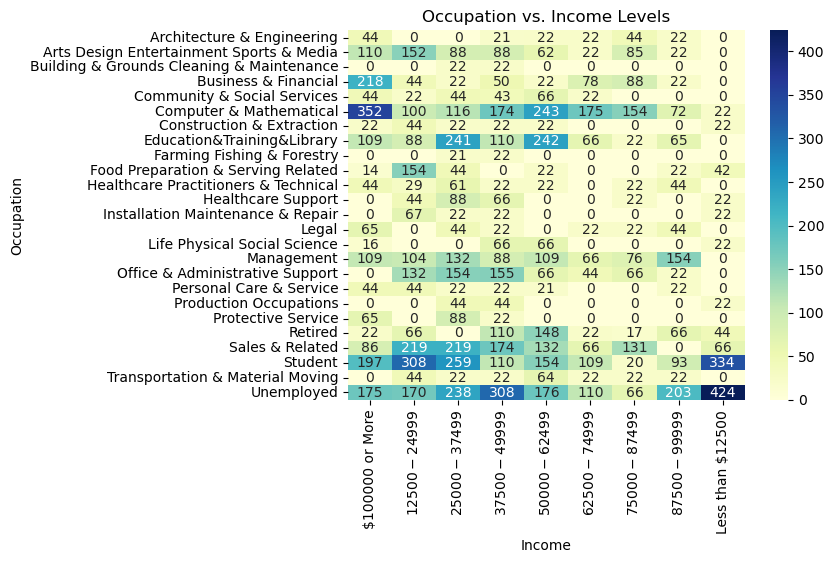

In [119]:
# Cross-tabulate occupation and income
crosstab = pd.crosstab(x['occupation'], x['income'])

# Plot as heatmap
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Occupation vs. Income Levels")
plt.xlabel("Income")
plt.ylabel("Occupation")
plt.show()

In [120]:
x['income'].unique()

array(['$37500 - $49999', '$62500 - $74999', '$12500 - $24999',
       '$75000 - $87499', '$50000 - $62499', '$25000 - $37499',
       '$100000 or More', '$87500 - $99999', 'Less than $12500'],
      dtype=object)

In [121]:
# Define the order of categories
# Define the order of categories for each column
categories = {
    'age': ['below21', '21', '26', '31', '36', '41', '46', '50plus'],
    'education': ['Some High School', 
                  'High School Graduate', 
                  'Some college - no degree', 
                  'Associates degree', 
                  'Bachelors degree', 
                  'Graduate degree (Masters or Doctorate)'],
    'income': [ 'Less than $12500',
                '$12500 - $24999',
                '$25000 - $37499',
                '$37500 - $49999',
                '$50000 - $62499',
                '$62500 - $74999',
                '$75000 - $87499',
                '$87500 - $99999',
                '$100000 or More']
}
encoder = preprocessing.OrdinalEncoder(categories=[categories['age'], categories['education'], categories['income']])

# Fit and transform the age_group column
x[['age_encoded', 'education_encoded', 'income_encoded']] = encoder.fit_transform(x[['age', 'education', 'income']])
x = x.drop(columns=['age', 'education', 'income'])

# View the original and encoded DataFrame
x

,destination,passanger,weather,temperature,time,coupon,expiration,gender,maritalStatus,has_children,...,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,age_encoded,education_encoded,income_encoded
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,Unmarried partner,1,...,4~8,1~3,1,0,0,0,1,1.0,2.0,3.0
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,Unmarried partner,1,...,4~8,1~3,1,0,0,0,1,1.0,2.0,3.0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1.0,2.0,3.0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1.0,2.0,3.0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,Unmarried partner,1,...,4~8,1~3,1,1,0,0,1,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,Single,0,...,4~8,1~3,1,0,0,1,0,2.0,4.0,6.0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,Single,0,...,4~8,1~3,1,0,0,0,1,2.0,4.0,6.0
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,Single,0,...,4~8,1~3,1,0,0,1,0,2.0,4.0,6.0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,Single,0,...,4~8,1~3,1,1,1,0,1,2.0,4.0,6.0


In [122]:
ct = make_column_transformer(
(preprocessing.OneHotEncoder(sparse_output=False), 
["destination", "passanger", "weather", "temperature", "time", "coupon", "expiration", "gender", "maritalStatus", "occupation", "Bar", "car", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"]), 
remainder="passthrough")
ct.set_output(transform="pandas")
x = ct.fit_transform(x)
x

,onehotencoder__destination_Home,onehotencoder__destination_No Urgent Place,onehotencoder__destination_Work,onehotencoder__passanger_Alone,onehotencoder__passanger_Friend(s),onehotencoder__passanger_Kid(s),onehotencoder__passanger_Partner,onehotencoder__weather_Rainy,onehotencoder__weather_Snowy,onehotencoder__weather_Sunny,...,onehotencoder__Restaurant20To50_nan,remainder__has_children,remainder__toCoupon_GEQ5min,remainder__toCoupon_GEQ15min,remainder__toCoupon_GEQ25min,remainder__direction_same,remainder__direction_opp,remainder__age_encoded,remainder__education_encoded,remainder__income_encoded
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,1,0,0,0,1,1.0,2.0,3.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,1,0,0,0,1,1.0,2.0,3.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,1,1,0,0,1,1.0,2.0,3.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,1,1,0,0,1,1.0,2.0,3.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,1,1,0,0,1,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0,1,0,0,1,0,2.0,4.0,6.0
12680,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,1,0,0,0,1,2.0,4.0,6.0
12681,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,1,0,0,1,0,2.0,4.0,6.0
12682,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,1,1,1,0,1,2.0,4.0,6.0


In [123]:
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    display(x)

,onehotencoder__destination_Home,onehotencoder__destination_No Urgent Place,onehotencoder__destination_Work,onehotencoder__passanger_Alone,onehotencoder__passanger_Friend(s),onehotencoder__passanger_Kid(s),onehotencoder__passanger_Partner,onehotencoder__weather_Rainy,onehotencoder__weather_Snowy,onehotencoder__weather_Sunny,onehotencoder__temperature_30,onehotencoder__temperature_55,onehotencoder__temperature_80,onehotencoder__time_10AM,onehotencoder__time_10PM,onehotencoder__time_2PM,onehotencoder__time_6PM,onehotencoder__time_7AM,onehotencoder__coupon_Bar,onehotencoder__coupon_Carry out & Take away,onehotencoder__coupon_Coffee House,onehotencoder__coupon_Restaurant(20-50),onehotencoder__coupon_Restaurant(<20),onehotencoder__expiration_1d,onehotencoder__expiration_2h,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__maritalStatus_Divorced,onehotencoder__maritalStatus_Married partner,onehotencoder__maritalStatus_Single,onehotencoder__maritalStatus_Unmarried partner,onehotencoder__maritalStatus_Widowed,onehotencoder__occupation_Architecture & Engineering,onehotencoder__occupation_Arts Design Entertainment Sports & Media,onehotencoder__occupation_Building & Grounds Cleaning & Maintenance,onehotencoder__occupation_Business & Financial,onehotencoder__occupation_Community & Social Services,onehotencoder__occupation_Computer & Mathematical,onehotencoder__occupation_Construction & Extraction,onehotencoder__occupation_Education&Training&Library,onehotencoder__occupation_Farming Fishing & Forestry,onehotencoder__occupation_Food Preparation & Serving Related,onehotencoder__occupation_Healthcare Practitioners & Technical,onehotencoder__occupation_Healthcare Support,onehotencoder__occupation_Installation Maintenance & Repair,onehotencoder__occupation_Legal,onehotencoder__occupation_Life Physical Social Science,onehotencoder__occupation_Management,onehotencoder__occupation_Office & Administrative Support,onehotencoder__occupation_Personal Care & Service,onehotencoder__occupation_Production Occupations,onehotencoder__occupation_Protective Service,onehotencoder__occupation_Retired,onehotencoder__occupation_Sales & Related,onehotencoder__occupation_Student,onehotencoder__occupation_Transportation & Material Moving,onehotencoder__occupation_Unemployed,onehotencoder__Bar_1~3,onehotencoder__Bar_4~8,onehotencoder__Bar_gt8,onehotencoder__Bar_less1,onehotencoder__Bar_never,onehotencoder__Bar_nan,onehotencoder__car_Car that is too old to install Onstar :D,onehotencoder__car_Mazda5,onehotencoder__car_Scooter and motorcycle,onehotencoder__car_crossover,onehotencoder__car_do not drive,onehotencoder__car_nan,onehotencoder__CoffeeHouse_1~3,onehotencoder__CoffeeHouse_4~8,onehotencoder__CoffeeHouse_gt8,onehotencoder__CoffeeHouse_less1,onehotencoder__CoffeeHouse_never,onehotencoder__CoffeeHouse_nan,onehotencoder__CarryAway_1~3,onehotencoder__CarryAway_4~8,onehotencoder__CarryAway_gt8,onehotencoder__CarryAway_less1,onehotencoder__CarryAway_never,onehotencoder__CarryAway_nan,onehotencoder__RestaurantLessThan20_1~3,onehotencoder__RestaurantLessThan20_4~8,onehotencoder__RestaurantLessThan20_gt8,onehotencoder__RestaurantLessThan20_less1,onehotencoder__RestaurantLessThan20_never,onehotencoder__RestaurantLessThan20_nan,onehotencoder__Restaurant20To50_1~3,onehotencoder__Restaurant20To50_4~8,onehotencoder__Restaurant20To50_gt8,onehotencoder__Restaurant20To50_less1,onehotencoder__Restaurant20To50_never,onehotencoder__Restaurant20To50_nan,remainder__has_children,remainder__toCoupon_GEQ5min,remainder__toCoupon_GEQ15min,remainder__toCoupon_GEQ25min,remainder__direction_same,remainder__direction_opp,remainder__age_encoded,remainder__education_encoded,remainder__income_encoded
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [124]:
def neural_network(layers, nodes, acti_name):
    hidden_layer_size =  (nodes,) * layers
    mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_layer_size, max_iter=1000, activation=acti_name, solver="adam", random_state=2)
    kfold = model_selection.KFold(5, shuffle=True, random_state=2)
    prec, rec, f1 = [], [], []
    x_scaler = preprocessing.MinMaxScaler() 
    start = time.time()
    for train_idx, test_idx in kfold.split(x):
        x_train, x_test =  x[train_idx], x[test_idx]
        y_train, y_test =  y[train_idx], y[test_idx]

        x_train = x_scaler.fit_transform(x_train)
        x_test = x_scaler.transform(x_test)

        mlp_clf.fit(x_train, y_train)
        
        y_pred = mlp_clf.predict(x_test)
        
        
        rec += [metrics.recall_score(y_test, y_pred, average="weighted")]
        prec += [metrics.precision_score(y_test, y_pred, average="weighted")]
        f1 += [metrics.f1_score(y_test, y_pred, average="weighted")]
    time_spent = time.time() - start
    
    return time_spent, np.mean(rec), np.std(rec), np.mean(prec), np.std(prec), np.mean(f1), np.std(f1)


In [125]:
x = x.to_numpy()  # or x.values
y = y.to_numpy()  # or y.values

print("2 hidden layers with 20 nodes in each layer with relu activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(2, 20, acti_name="relu")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("2 hidden layers with 100 nodes in each layer with relu activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(2, 100, acti_name="relu")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("5 hidden layers with 20 nodes in each layer with relu activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(5, 20, acti_name="relu")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("5 hidden layers with 100 nodes in each layer with relu activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(5, 100, acti_name="relu")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("2 hidden layers with 20 nodes in each layer with tanh activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(2, 20, acti_name="tanh")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("2 hidden layers with 100 nodes in each layer with tanh activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(2, 100, acti_name="tanh")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("5 hidden layers with 20 nodes in each layer with tanh activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(5, 20, acti_name="tanh")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

print("5 hidden layers with 100 nodes in each layer with tanh activation")
time_spent, mean_rec, std_rec, mean_prec, std_prec, mean_f1, std_f1 = neural_network(5, 100, acti_name="tanh")
print(f"Time spent: {time_spent:.4f}s, Recall: {mean_rec:.4f} ± {std_rec:.4f}, Precision: {mean_prec:.4f} ± {std_prec:.4f}, F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

2 hidden layers with 20 nodes in each layer with relu activation
Time spent: 159.5042s, Recall: 0.7165 ± 0.0050, Precision: 0.7156 ± 0.0053, F1 Score: 0.7156 ± 0.0053
2 hidden layers with 100 nodes in each layer with relu activation
Time spent: 129.6214s, Recall: 0.7252 ± 0.0021, Precision: 0.7262 ± 0.0027, F1 Score: 0.7254 ± 0.0023
5 hidden layers with 20 nodes in each layer with relu activation
Time spent: 115.3160s, Recall: 0.6940 ± 0.0080, Precision: 0.6942 ± 0.0067, F1 Score: 0.6938 ± 0.0074
5 hidden layers with 100 nodes in each layer with relu activation
Time spent: 178.4395s, Recall: 0.7172 ± 0.0067, Precision: 0.7176 ± 0.0051, F1 Score: 0.7166 ± 0.0060
2 hidden layers with 20 nodes in each layer with tanh activation


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Time spent: 401.4569s, Recall: 0.6932 ± 0.0057, Precision: 0.6938 ± 0.0045, F1 Score: 0.6932 ± 0.0052
2 hidden layers with 100 nodes in each layer with tanh activation
Time spent: 307.6305s, Recall: 0.7312 ± 0.0059, Precision: 0.7310 ± 0.0062, F1 Score: 0.7306 ± 0.0064
5 hidden layers with 20 nodes in each layer with tanh activation
Time spent: 327.6856s, Recall: 0.6921 ± 0.0048, Precision: 0.6919 ± 0.0052, F1 Score: 0.6919 ± 0.0050
5 hidden layers with 100 nodes in each layer with tanh activation
Time spent: 335.8998s, Recall: 0.7180 ± 0.0036, Precision: 0.7189 ± 0.0024, F1 Score: 0.7182 ± 0.0033


In [126]:
import matplotlib.pyplot as plt

# Parameters for experiment 1
layer_sizes = [40, 80, 120, 160, 200]
layers_fixed = 2
times_for_sizes = []
mean_f1_scores = []

for size in layer_sizes:
    time_spent, _, _, _, _, mean_f1, _ = neural_network(layers=layers_fixed, nodes=size, acti_name="relu")
    times_for_sizes.append(time_spent)
    mean_f1_scores.append(mean_f1)

In [128]:
# Parameters for experiment 2
layer_counts = [1, 2, 3, 4, 5, 6, 7, 8]
nodes_fixed = 20
times_for_layer_counts = []
mean_f1_scores_count = []

for num_layers in layer_counts:
    time_spent, _, _, _, _, mean_f1, _ = neural_network(layers=num_layers, nodes=nodes_fixed, acti_name="relu")
    times_for_layer_counts.append(time_spent)
    mean_f1_scores_count.append(mean_f1)


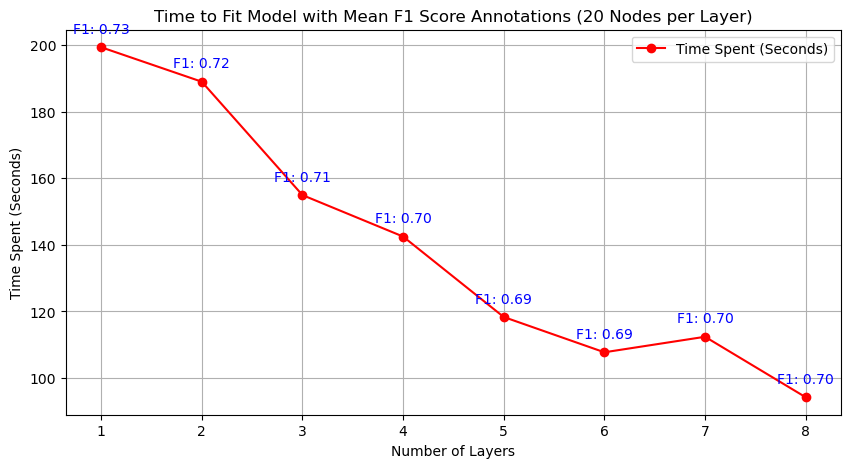

In [129]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plot time spent
plt.plot(layer_counts, times_for_layer_counts, marker='o', color='r', label='Time Spent (Seconds)')

# Add annotations for mean F1 scores above each point in the time spent graph
for i, score in enumerate(mean_f1_scores_count):
    plt.annotate(f"F1: {score:.2f}", (layer_counts[i], times_for_layer_counts[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

plt.title('Time to Fit Model with Mean F1 Score Annotations (20 Nodes per Layer)')
plt.xlabel('Number of Layers')
plt.ylabel('Time Spent (Seconds)')
plt.grid(True)
plt.legend()
plt.show()